<h1>Advanced Data Science Capstone</h1>
<h3>Fred V</h3>
<br>
<h2>Data Exploration</h2>

Download last.fm Dataset

In [1]:
!rm -rf lastfm-dataset-360K*
!wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz

--2020-08-08 12:59:21--  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz
Resolving mtg.upf.edu (mtg.upf.edu)... 84.89.139.55
Connecting to mtg.upf.edu (mtg.upf.edu)|84.89.139.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569202935 (543M) [application/x-gzip]
Saving to: ‘lastfm-dataset-360K.tar.gz’

100%[======================================>] 569,202,935 3.07MB/s   in 2m 0s  

2020-08-08 13:01:21 (4.54 MB/s) - ‘lastfm-dataset-360K.tar.gz’ saved [569202935/569202935]



   Unzip dataset

In [2]:
!tar zxvf lastfm-dataset-360K.tar.gz

lastfm-dataset-360K/
lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv
lastfm-dataset-360K/README.txt
lastfm-dataset-360K/mbox_sha1sum.py
lastfm-dataset-360K/usersha1-profile.tsv


In [3]:
# Installing pyspark
!pip install pyspark


     |████████████████████████████████| 204.7MB 52.3MB/s eta 0:00:01     |█████████████████▊              | 113.6MB 49.3MB/s eta 0:00:02��██████████████▏   | 180.2MB 51.2MB/s eta 0:00:01
     |████████████████████████████████| 204kB 38.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [4]:
# Preparing Env
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sc = SparkContext()
sqlContext = SQLContext(sc)
path = "lastfm-dataset-360K/"

Importing the Artist / Play Dataset

In [5]:
playsDataSchema = StructType([StructField("userID", StringType(), True), StructField("artistID", StringType(), True), StructField("artistName", StringType(), True), StructField("playNum", IntegerType(), True)])

plays = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter="\t") \
    .load(path + "usersha1-artmbid-artname-plays.tsv", schema = playsDataSchema) \
    .cache()

plays.cache()
plays.show()


+--------------------+--------------------+--------------------+-------+
|              userID|            artistID|          artistName|playNum|
+--------------------+--------------------+--------------------+-------+
|00000c289a1829a80...|3bd73256-3905-4f3...|     betty blowtorch|   2137|
|00000c289a1829a80...|f2fb0ff0-5679-42e...|           die Ärzte|   1099|
|00000c289a1829a80...|b3ae82c2-e60b-455...|   melissa etheridge|    897|
|00000c289a1829a80...|3d6bbeb7-f90e-4d1...|           elvenking|    717|
|00000c289a1829a80...|bbd2ffd7-17f4-450...|juliette & the licks|    706|
|00000c289a1829a80...|8bfac288-ccc5-448...|red hot chili pep...|    691|
|00000c289a1829a80...|6531c8b1-76ea-414...|              magica|    545|
|00000c289a1829a80...|21f3573f-10cf-44b...|the black dahlia ...|    507|
|00000c289a1829a80...|c5db90c4-580d-4f3...|         the murmurs|    424|
|00000c289a1829a80...|0639533a-0402-40b...|          lunachicks|    403|
|00000c289a1829a80...|a342964d-ca53-4e5...|    wall

In [6]:
usersDataSchema = StructType([StructField("userID", StringType(), True), StructField("userGender", StringType(), True), StructField("userAge", IntegerType(), True), StructField("userCountry", StringType(), True), StructField("userSignupDate", StringType(), True)])

users = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter="\t") \
    .load(path + "usersha1-profile.tsv", schema = usersDataSchema) \
    .cache()

users.cache()
users.show()

+--------------------+----------+-------+--------------+--------------+
|              userID|userGender|userAge|   userCountry|userSignupDate|
+--------------------+----------+-------+--------------+--------------+
|00000c289a1829a80...|         f|     22|       Germany|   Feb 1, 2007|
|00001411dc427966b...|         f|   null|        Canada|   Dec 4, 2007|
|00004d2ac9316e22d...|      null|   null|       Germany|   Sep 1, 2006|
|000063d3fe1cf2ba2...|         m|     19|        Mexico|  Apr 28, 2008|
|00007a47085b9aab8...|         m|     28| United States|  Jan 27, 2006|
|0000c176103e538d5...|         m|     20|United Kingdom|  Jan 14, 2006|
|0000ee7dd906373ef...|         m|     17|       Finland|  Nov 17, 2007|
|0000ef373bbd0d89c...|         f|     22|        Poland|  May 23, 2007|
|0000f687d4fe9c1ed...|         f|     24|         Spain|   Nov 4, 2008|
|0001399387da41d55...|         m|   null|       Ukraine|  Aug 17, 2008|
|000163263d2a41a39...|         m|     27|        Sweden|   Jan 5

In [7]:
print("Total number of rows in Plays DF: " + str(plays.count()))

Total number of rows in Plays DF: 17559530


In [8]:
print("Total number of rows in Users DF: " + str(users.count()))

Total number of rows in Users DF: 359347


Are there users that could benefit a Recommendation System?

In [9]:
usersPlay = plays.groupBy('userID').sum('playNum').orderBy('sum(playNum)').collect()
print(usersPlay[0:10])

[Row(userID='da315b69d495c2081ac35867a7deadfe197b7e84', sum(playNum)=1), Row(userID='23cce0df9623cd6cbef59ac70a5e4fe541fb21e8', sum(playNum)=1), Row(userID='b7c138c80b7581c47ffedfcfc9875275eee8ab0c', sum(playNum)=1), Row(userID='fb540135cea0985ff7a7b3f769b66601a8bc3eb2', sum(playNum)=1), Row(userID='9375eab9f22dbd83e308e64e9670f3a0c0228ab8', sum(playNum)=1), Row(userID='fdb8cd010228f711cecc2ed0430795af2d07a907', sum(playNum)=1), Row(userID='727ea7fae9190199803d0e3da5dab77e3a3ef056', sum(playNum)=1), Row(userID='17fb7e08b0095ef17cb2ffc2f80014abf73d2861', sum(playNum)=1), Row(userID='ddf4f778a4623ec7fd8b6f93e528789d60db5ca1', sum(playNum)=1), Row(userID='8197f06a3437d1f66f2e12e30738b511d6e7c6e8', sum(playNum)=2)]


Looks like quite a few users are not using the system ... let's boxplot the data

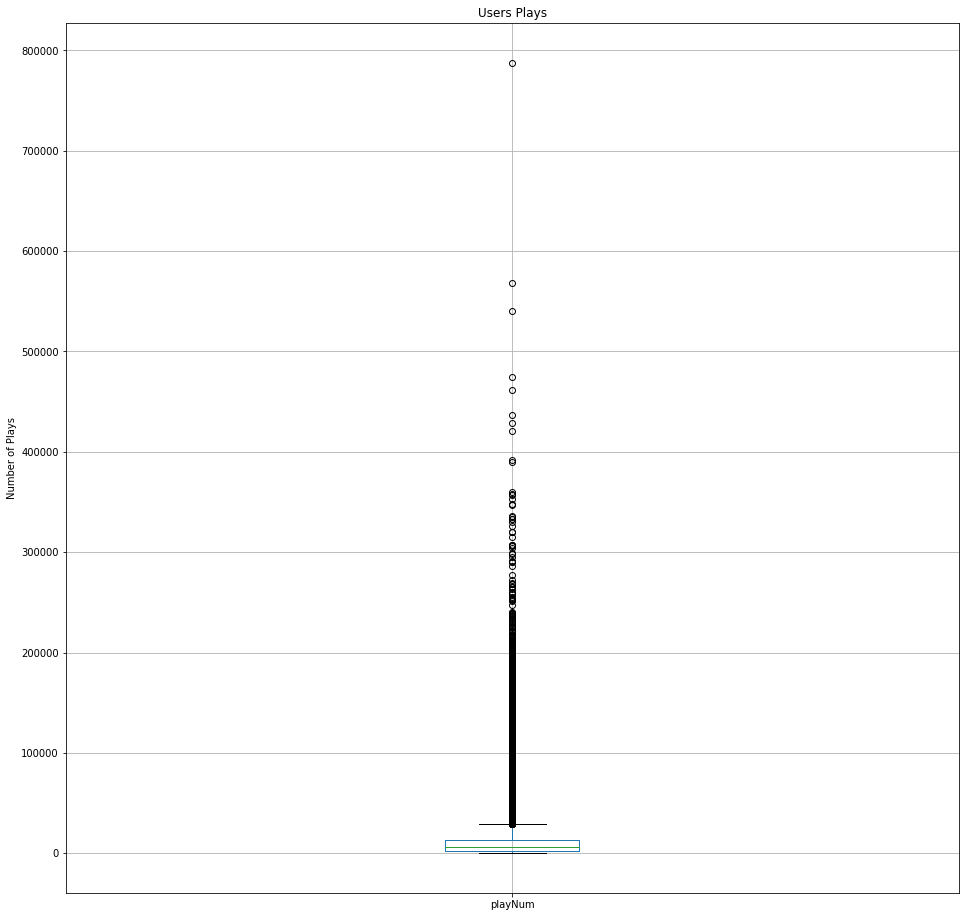

In [10]:
pdf = pd.DataFrame(data=usersPlay)
pdf.columns = [ 'userID', 'playNum' ]
#pdf.head()

fig = plt.figure(figsize=(16,16))
ax2 = fig.gca()
pdf.boxplot(column='playNum', ax=ax2)
ax2.set_title('Users Plays')
ax2.set_ylabel('Number of Plays')
plt.suptitle('')
plt.show()

We can clearly see that, from the BoxPlot, that the usage is very low ...

In [11]:
Y=np.sort( pdf['playNum'] )
print ('Total =', Y.sum())
print ('Mean =', Y.mean())
print ('Min =', Y.min())
print ('Max =', Y.max())
print('Percentile 25% :' + str(np.percentile(Y,25)))
print('Percentile 50% :' + str(np.percentile(Y,50)))
print('Percentile 75% :' + str(np.percentile(Y,75)))
print('Percentile 90% :' + str(np.percentile(Y,90)))
print('Percentile 95% :' + str(np.percentile(Y,95)))
print('Percentile 99% :' + str(np.percentile(Y,99)))

Total = 3778552384
Mean = 10514.99345761363
Min = 1
Max = 787884
Percentile 25% :2402.0
Percentile 50% :6140.0
Percentile 75% :13131.0
Percentile 90% :24102.0
Percentile 95% :34264.19999999995
Percentile 99% :68283.68000000017


Let's look into the artistName / artistID issue

In [12]:
plays[locate("black eyed peas", plays.artistName) > 0].show(50, False)

+----------------------------------------+------------------------------------+-----------------------------------+-------+
|userID                                  |artistID                            |artistName                         |playNum|
+----------------------------------------+------------------------------------+-----------------------------------+-------+
|0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20|d5be5333-4171-427e-8e12-732087c6b78e|black eyed peas                    |12     |
|000ac3838c0889b96c9adb7a3e21dbfa0f29db1f|d5be5333-4171-427e-8e12-732087c6b78e|black eyed peas                    |90     |
|000ce88030356b95cbc2281e69786a8ecd9de308|d5be5333-4171-427e-8e12-732087c6b78e|black eyed peas                    |71     |
|0010a39ea8da840485454098519f5c7428609ba2|d5be5333-4171-427e-8e12-732087c6b78e|black eyed peas                    |3      |
|001298c4623ec8dff76356ec0333c5d62a78fe94|d5be5333-4171-427e-8e12-732087c6b78e|black eyed peas                    |7      |
|0014e7d

We can see an annoying null in the artistID column. Which leads me to think that actually the artistID column is pretty clean. So I'm removing all records where artistID is null

In [13]:
plays = plays[plays.artistID.isNotNull()]

In [14]:
plays.count()

17333078

Quick check on null values for artistName too

In [15]:
plays = plays[plays.artistName.isNotNull()]

In [16]:
plays.count()

17333078

Those were clean already. Oh well, same old paranoid me ...<br>
Then I can start preparing the Dataset for Modelling, by dropping unwanted Columns from Plays DF

In [17]:
plays_clean= plays.drop('artistName') 
plays_clean.show()

+--------------------+--------------------+-------+
|              userID|            artistID|playNum|
+--------------------+--------------------+-------+
|00000c289a1829a80...|3bd73256-3905-4f3...|   2137|
|00000c289a1829a80...|f2fb0ff0-5679-42e...|   1099|
|00000c289a1829a80...|b3ae82c2-e60b-455...|    897|
|00000c289a1829a80...|3d6bbeb7-f90e-4d1...|    717|
|00000c289a1829a80...|bbd2ffd7-17f4-450...|    706|
|00000c289a1829a80...|8bfac288-ccc5-448...|    691|
|00000c289a1829a80...|6531c8b1-76ea-414...|    545|
|00000c289a1829a80...|21f3573f-10cf-44b...|    507|
|00000c289a1829a80...|c5db90c4-580d-4f3...|    424|
|00000c289a1829a80...|0639533a-0402-40b...|    403|
|00000c289a1829a80...|a342964d-ca53-4e5...|    393|
|00000c289a1829a80...|f779ed95-66c8-449...|    387|
|00000c289a1829a80...|7b885d42-3c41-4f4...|    361|
|00000c289a1829a80...|e000d76b-afff-428...|    358|
|00000c289a1829a80...|adf334c2-9186-48c...|    329|
|00000c289a1829a80...|7e870dd5-2667-454...|    316|
|00000c289a1

I also need to transform userID and artistID into INT to make it work with Classification Algorithms ...

In [18]:
import pyspark.sql.functions as F
plays_clean2 = plays_clean.withColumn("userID", F.hash(col("userID")))
plays_clean3 = plays_clean2.withColumn("artistID", F.hash(col("artistID")))
plays_clean3.show()

+----------+-----------+-------+
|    userID|   artistID|playNum|
+----------+-----------+-------+
|2021926906| -715321519|   2137|
|2021926906|  506628817|   1099|
|2021926906| -422168865|    897|
|2021926906|  639507509|    717|
|2021926906| 1452181926|    706|
|2021926906|-1379753189|    691|
|2021926906| -771036012|    545|
|2021926906| 1929585954|    507|
|2021926906|  249108186|    424|
|2021926906| -658682499|    403|
|2021926906|-1688693180|    393|
|2021926906| -935332680|    387|
|2021926906| -381022105|    361|
|2021926906| -844727787|    358|
|2021926906|-2105770962|    329|
|2021926906|  838341029|    316|
|2021926906| -872494528|    310|
|2021926906|  984718954|    302|
|2021926906|  993299978|    288|
|2021926906| -675854376|    281|
+----------+-----------+-------+
only showing top 20 rows



Making sure there are no null values ...

In [19]:
plays_clean3 = plays_clean3[plays_clean3.userID.isNotNull()]
plays_clean3 = plays_clean3[plays_clean3.artistID.isNotNull()]
plays_clean3 = plays_clean3[plays_clean3.playNum.isNotNull()]

Saving new DF to a file

In [20]:
plays_clean3.write.format("com.databricks.spark.csv").save(path + 'plays_clean3new.csv')

In [21]:
!head lastfm-dataset-360K/plays_clean3new.csv/*

==> lastfm-dataset-360K/plays_clean3new.csv/part-00000-8da72b5a-b5bf-4d98-94f5-33cf7bf4f98e-c000.csv <==
2021926906,-715321519,2137
2021926906,506628817,1099
2021926906,-422168865,897
2021926906,639507509,717
2021926906,1452181926,706
2021926906,-1379753189,691
2021926906,-771036012,545
2021926906,1929585954,507
2021926906,249108186,424
2021926906,-658682499,403

==> lastfm-dataset-360K/plays_clean3new.csv/part-00001-8da72b5a-b5bf-4d98-94f5-33cf7bf4f98e-c000.csv <==
1646788380,-474329593,25
1646788380,1443079382,24
1646788380,764601092,24
1646788380,-710820584,23
1646788380,1980534526,22
1646788380,1943568989,19
1646788380,-561637813,19
1646788380,-1828566203,16
1646788380,-708411785,15
1646788380,-418413290,15

==> lastfm-dataset-360K/plays_clean3new.csv/part-00002-8da72b5a-b5bf-4d98-94f5-33cf7bf4f98e-c000.csv <==
-1301586572,-1095254126,11
-1301586572,1408171179,11
-1301586572,-1830953198,11
-1301586572,2020869092,10
-1301586572,2037924821,10
-1301586572,255719877,10
-1301586572,1804

## Model Training ##

In [22]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [23]:
#raw = sc.textFile(path + "plays_clean3new.csv")
rawRDD = plays_clean3.rdd
rawRDD.take(5)

[Row(userID=2021926906, artistID=-715321519, playNum=2137),
 Row(userID=2021926906, artistID=506628817, playNum=1099),
 Row(userID=2021926906, artistID=-422168865, playNum=897),
 Row(userID=2021926906, artistID=639507509, playNum=717),
 Row(userID=2021926906, artistID=1452181926, playNum=706)]

In [24]:
data = rawRDD.map(lambda r: Rating( int(r[0]),int(r[1]),int(r[2]))).repartition(12).cache()
data.take(5)

[Rating(user=-1047240920, product=1436308646, rating=135.0),
 Rating(user=-1047240920, product=1733143242, rating=121.0),
 Rating(user=-1047240920, product=-1718003804, rating=119.0),
 Rating(user=-1047240920, product=408590364, rating=114.0),
 Rating(user=-1047240920, product=483493729, rating=110.0)]

In [25]:
# splitting 70/30
trainData, cvData = data.randomSplit([0.7,0.3],1)
trainData.cache()
cvData.cache()

rank=10
iterations=5
lambda_=0.01
alpha=1.0
model = ALS.trainImplicit(ratings=trainData,rank=rank,iterations=iterations,lambda_=lambda_ ,alpha=alpha)

In [26]:
model.userFeatures().first()

(-2147481324,
 array('d', [-0.19717960059642792, 0.244133859872818, -0.2109711766242981, 0.2433737814426422, -0.24148105084896088, -0.3318879306316376, -0.30036458373069763, 0.042220864444971085, 0.30054160952568054, 0.04581376165151596]))